# Deep Hedging of Green PPAs

In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from scipy.special import comb
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, LinearDemandForwardModel
from rivapy.instruments.ppa_specification import GreenPPASpecification
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
from rivapy.models import OrnsteinUhlenbeck
from rivapy.pricing.green_ppa_pricing import GreenPPADeepHedgingPricer, DeepHedgeModel

import analysis

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/doeltz/doeltz/development/RiVaPy/sandbox/green_ppa/../../rivapy/__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')
2023-08-18 13:30:47.428353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-18 13:30:47.428369: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Residual Demand Forward Model

In [2]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forward_expiries = [timegrid[-1]]

In [7]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=2.0, volatility=4.0)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=2.0, volatility=3.0)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

models = {
'additive': LinearDemandForwardModel(wind_power_forecast=wind, 
                                 x_volatility = 4.0 , 
                                 x_mean_reversion_speed = 0.1,
                                 power_name= 'Power_Germany'),

'multiplicative' : LinearDemandForwardModel(wind_power_forecast=wind, 
                                 x_volatility = 4.0 , 
                                 x_mean_reversion_speed = 0.1,
                                 power_name= 'Power_Germany', 
                                                additive_correction=False)
}

In [8]:
np.random.seed(42)
rnd = np.random.normal(size=models['additive'].rnd_shape(n_sims=10_000, n_timesteps=timegrid.shape[0]))
paths = {}
for k,model in models.items():
    paths[k] = model.simulate(timegrid, rnd, expiries=forward_expiries, 
                                     initial_forecasts={'Onshore': [0.9],
                                                        'Offshore': [0.6]},
                                    power_fwd_prices = [1.0])

/home/doeltz/doeltz/development/RiVaPy/sandbox/green_ppa/../../rivapy/models/residual_demand_fwd_model.py:472: RuntimeWarning: divide by zero encountered in double_scalars
  result[i] = power_fwd_prices[i]/((1.0-tmp) * self.highest_price_ou_model.compute_expected_value(startvalue, expiries[i]))


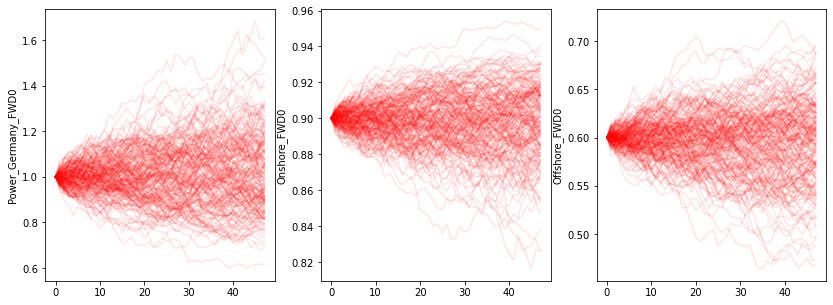

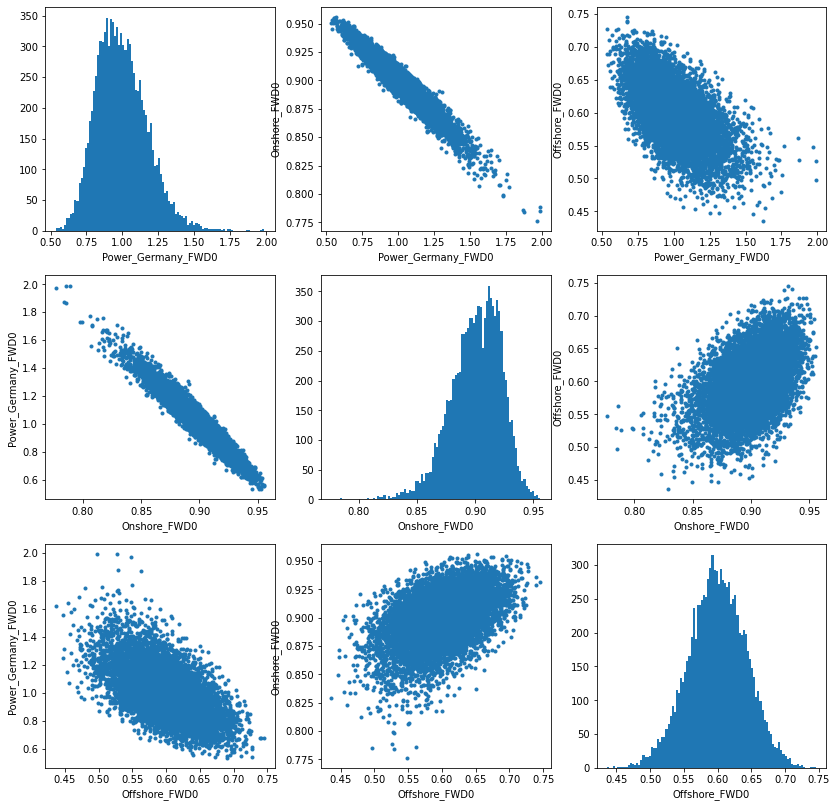

In [9]:
analysis.plot_paths(paths, None)